**Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving StudentsPerformance.csv to StudentsPerformance.csv


In [3]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import KFold, RepeatedKFold, ShuffleSplit, GridSearchCV, train_test_split,cross_val_score, validation_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from warnings import simplefilter

simplefilter('ignore')

In [4]:
df = pd.read_csv('./StudentsPerformance.csv', sep=',')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
df["gender"] = le.fit_transform(df[['gender']])
df["race/ethnicity"] = le.fit_transform(df[['race/ethnicity']])
df["parental level of education"] = le.fit_transform(df[['parental level of education']])
df["lunch"] = le.fit_transform(df[['lunch']])
df["test preparation course"] = le.fit_transform(df[['test preparation course']])
df.head(10)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,1,1,1,1,72,72,74
1,0,2,4,1,0,69,90,88
2,0,1,3,1,1,90,95,93
3,1,0,0,0,1,47,57,44
4,1,2,4,1,1,76,78,75
5,0,1,0,1,1,71,83,78
6,0,1,4,1,0,88,95,92
7,1,1,4,0,1,40,43,39
8,1,3,2,0,0,64,64,67
9,0,1,2,0,1,38,60,50


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   gender                       1000 non-null   int64
 1   race/ethnicity               1000 non-null   int64
 2   parental level of education  1000 non-null   int64
 3   lunch                        1000 non-null   int64
 4   test preparation course      1000 non-null   int64
 5   math score                   1000 non-null   int64
 6   reading score                1000 non-null   int64
 7   writing score                1000 non-null   int64
dtypes: int64(8)
memory usage: 62.6 KB


In [7]:
df.dropna()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,1,1,1,1,72,72,74
1,0,2,4,1,0,69,90,88
2,0,1,3,1,1,90,95,93
3,1,0,0,0,1,47,57,44
4,1,2,4,1,1,76,78,75
...,...,...,...,...,...,...,...,...
995,0,4,3,1,0,88,99,95
996,1,2,2,0,1,62,55,55
997,0,2,2,0,0,59,71,65
998,0,3,4,1,0,68,78,77


Видим, в датасете нет пропусков и нет категориальных признаков. Отделим целевой признак.

In [8]:
y = df['writing score']
X = df.drop('writing score', axis=1)

Разделим выборку на обучающую и тестовую

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Обучение методом k ближайших соседей с произвольным k


In [10]:
def print_metrics(y_test, y_pred):
    print(f"R^2_score: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    


Возьмем k=5

In [11]:
regr_5 = KNeighborsRegressor(n_neighbors=5)
regr_5.fit(x_train, y_train)

KNeighborsRegressor()

In [12]:
print_metrics(y_test, regr_5.predict(x_test))

R^2_score: 0.8972447325769854
MSE: 24.092
MAE: 3.958


Кросс-валидация


Стратегия K-fold

In [13]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=KFold(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.92246926 0.90579614 0.86909023 0.89364136 0.86464956 0.91996437
 0.87964346 0.91824669 0.89737818 0.91410384]
0.8984983068096172 ± 0.020280804234952616


Стратегия Repeated K-fold

In [14]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=RepeatedKFold(n_splits=5, n_repeats=2),
                         scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.88961704 0.89370774 0.89760101 0.90696946 0.90206761 0.9033429
 0.90635757 0.88743281 0.89955462 0.89073663]
0.8977387361904201 ± 0.0067112256074918905


Стратегия ShuffleSplit

In [15]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=ShuffleSplit(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.90326021 0.86244072 0.90816853 0.86445766 0.9202195  0.9168318
 0.89374    0.91924168 0.90938616 0.87041162]
0.8968157881181045 ± 0.021714186943487472


Подбор гиперпараметра **K**

In [16]:
n_range = np.array(range(1, 30, 2))
tuned_parameters = [{'n_neighbors': n_range}]
n_range

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])

In [17]:
gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.cv_results_

{'mean_fit_time': array([0.00549212, 0.00537126, 0.00585384, 0.00474355, 0.00511723,
        0.004353  , 0.0044637 , 0.00437434, 0.00444372, 0.00435209,
        0.00485342, 0.00483873, 0.00429199, 0.00440876, 0.00463309]),
 'mean_score_time': array([0.00468709, 0.00453844, 0.00510974, 0.00439   , 0.00433652,
        0.00530894, 0.00427217, 0.00428851, 0.00504336, 0.00458083,
        0.00449185, 0.00498962, 0.00506175, 0.0044831 , 0.00463092]),
 'mean_test_score': array([0.84546535, 0.8878086 , 0.89244855, 0.89281545, 0.89404747,
        0.89712456, 0.89601292, 0.89595066, 0.89730838, 0.89829915,
        0.89747331, 0.89710962, 0.89676921, 0.89566678, 0.89586131]),
 'mean_train_score': array([0.99932418, 0.94837253, 0.93499449, 0.9274694 , 0.92291603,
        0.92037979, 0.91828192, 0.91643591, 0.9150119 , 0.91435475,
        0.91346558, 0.91236729, 0.91135511, 0.91044726, 0.90943399]),
 'param_n_neighbors': masked_array(data=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29],
    

In [ ]:
gs.best_params_

{'n_neighbors': 23}

In [18]:
gs.best_score_

0.8982991535077194

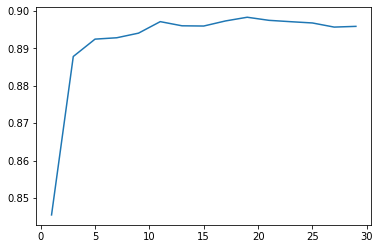

In [19]:
plt.plot(n_range, gs.cv_results_["mean_test_score"]);

На графике видно, что наилучшее значение достигается в районе 20 соседей


In [25]:
regr_best = KNeighborsRegressor(**gs.best_params_)
best_k=23
regr_best.fit(x_train, y_train)
print_metrics(y_test, regr_best.predict(x_test))

R^2_score: 0.9016384794623256
MSE: 23.061842105263157
MAE: 3.766578947368421


In [21]:
result = pd.DataFrame({'y_test': y_test, 'y_best_predict': regr_best.predict(x_test)}).sort_values(by='y_test')
result.head()

,y_test,y_best_predict
59,10,31.263158
17,28,31.263158
555,33,37.263158
84,34,40.894737
331,35,41.210526


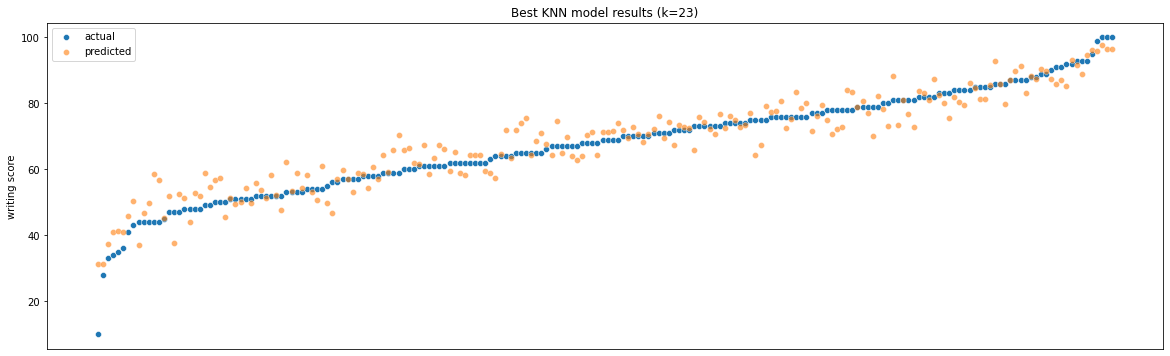

In [30]:
plt.figure(figsize=(20, 6))
sns.scatterplot(range(result.shape[0]), result['y_test'], label='actual')
sns.scatterplot(range(result.shape[0]), result['y_best_predict'], label='predicted', alpha=0.6)
plt.ylabel('writing score')
plt.xlabel('')
plt.title(f'Best KNN model results (k={best_k})')
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()